# Introduction to seismic modelling - 2D acoustic propagator

In this notebook we will highlight various aspects of seismic inversion based on Devito operators. Here we aim to highlight the core ideas behind seismic modelling, where we create a numerical model that captures the processes involved in a seismic survey. This forward model will then form the basis for further 'additional' tutorials (located in `additional_material`) on the implementation of inversion processes using Devito operators.

## Goals

- Introduce the seismic `Model` class
- Introduce 'sources' and 'receivers' (sparse operations)
- Build an acoustic forward propagator

## Modelling workflow

The core process we are aiming to model is a seismic survey, which consists of two main components:

- **Source** - A source is positioned at a single or a few physical locations where artificial pressure is injected into the domain we want to model. In the case of land survey, it is usually dynamite blowing up at a given location, or a vibroseis (a vibrating engine generating continuous sound waves). For a marine survey, the source is an air gun sending a bubble of compressed air into the water that will expand and generate a seismic wave.
- **Receiver** - A set of microphones or hydrophones are used to measure the resulting wave and create a set of measurements called a *Shot Record*. These measurements are recorded at multiple locations, and usually at the surface of the domain or at the bottom of the ocean in some marine cases.

In order to create a numerical model of a seismic survey, we need to solve the wave equation and implement source and receiver interpolation to inject the source and record the seismic wave at sparse point locations in the grid.


<img src='./figures/survey-ship-diagram.png' width=400>

## The acoustic seismic wave equation
The acoustic wave equation for the square slowness $m$, defined as $m=\frac{1}{c^2}$, where $c$ is the speed of sound in the given physical media, and a source $q$ is given by:

\begin{cases}
 &m \frac{\partial^2 u(\mathbf{x},t)}{\partial t^2} - \nabla^2 u(\mathbf{x},t) = q \ \text{in } \Omega \\
 &u(\mathbf{x},0) = 0 \\
 &\frac{\partial u(\mathbf{x},t)}{\partial t}|_{t=0} = 0 
\end{cases}

with the zero initial conditions to guarantee unicity of the solution.
The boundary conditions are Dirichlet conditions:
\begin{equation}
 u(\mathbf{x},t)|_{\delta\Omega} = 0
\end{equation}

where $\delta\Omega$ is the surface of the boundary of the model $\Omega$.


# Finite domains

The last piece of the puzzle is the computational limitation. In the field, the seismic wave propagates in every direction to an ''infinite'' distance. However, solving the wave equation in a mathematically/discrete infinite domain is not feasible. In order to compensate, Absorbing Boundary Conditions (ABC) or Perfectly Matched Layers (PML) are required to mimic an infinite domain. These two methods allow us to approximate an unbounded media by damping and absorbing the waves at the limit of the domain to avoid reflections.

The simplest of these methods is the absorbing damping mask. (Note that we will explore the implementation of a more sophisticated boundary condition in the following notebook).The core idea is to extend the physical domain and to add a *sponge mask* in this extension that will absorb the incident waves. The acoustic wave equation with this damping mask can be rewritten as:

\begin{cases} 
 &m \frac{\partial^2 u(\mathbf{x},t)}{\partial t^2} - \nabla^2 u(\mathbf{x},t) + \eta \frac{\partial u(\mathbf{x},t)}{\partial t}=q  \ \text{in } \Omega \\
 &u(\mathbf{x},0) = 0 \\
 &\frac{\partial u(\mathbf{x},t)}{\partial t}|_{t=0} = 0 
\end{cases}

where $\eta$ is the damping mask which is equal to $0$ inside the physical domain and increasing inside the sponge layer. Multiple choice of profile can be chosen for $\eta$ from, e.g., linear to exponential.

# Seismic modelling with devito

We describe here a step by step setup of seismic modelling with Devito in a simple 2D case. We will create a physical model of our domain and define a single source along with a set of receivers. But first, we initialize some basic utilities.

In [22]:
import numpy as np
%matplotlib inline

## Define the physical problem

The first step is to define the physical model:

- What are the physical dimensions of interest
- What is the velocity profile of this physical domain

We will create a simple velocity model here by hand for demonstration purposes. This model essentially consists of two layers, each with a different velocity: $1.5km/s$ in the top layer and $2.5km/s$ in the bottom layer. We will use this simple model a lot in the following tutorials, so we will rely on a utility function to create it again later.

Operator `initdamp` ran in 0.01 s


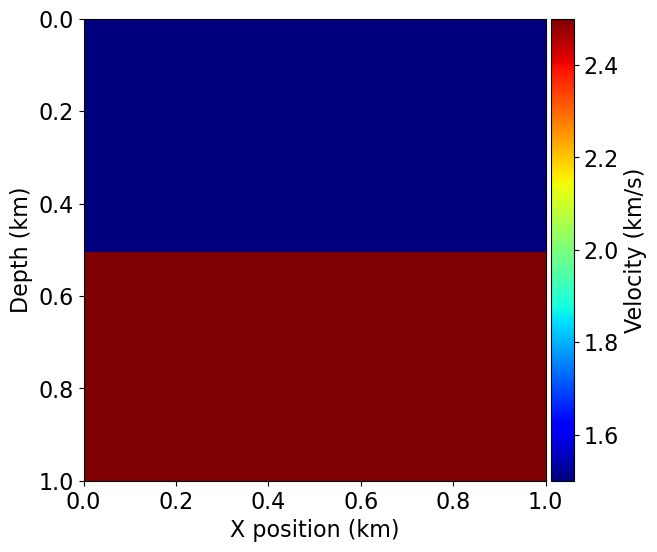

In [23]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import Model, plot_velocity

# Define a physical size
shape = (101, 101)  # Number of grid point (nx, nz)
spacing = (10., 10.)  # Grid spacing in m. The domain size is now 1km by 1km
origin = (0., 0.)  # What is the location of the top left corner. This is necessary to define
# the absolute location of the source and receivers

# Define a velocity profile. The velocity is in km/s
v = np.empty(shape, dtype=np.float32)
v[:, :51] = 1.5
v[:, 51:] = 2.5

# With the velocity and model size defined, we can create the seismic model that
# encapsulates this properties. We also define the size of the absorbing layer as 10 grid points
model = Model(vp=v, origin=origin, shape=shape, spacing=spacing,
              space_order=2, nbl=10, bcs="damp")

plot_velocity(model)

In [24]:
model.grid

Grid[extent=(1200.0, 1200.0), shape=(121, 121), dimensions=(x, y)]

# Acquisition geometry

To fully define our problem setup we also need to define the source that injects the wave to the model and the set of receiver locations at which to the wavefield is sampled. The source time signature will be modelled using a 'Ricker' wavelet whose form is defined as

\begin{equation}
  q(t) = (1-2\pi^2 f_0^2 (t - \frac{1}{f_0})^2 )e^{- \pi^2 f_0^2 (t - \frac{1}{f_0})}.
\end{equation}

To include such a source signature in our model we first need to define the time duration of our model and the timestep size, which is dictated by the CFL condition and our grid spacing. Luckily, our `Model` utility provides us with the critical timestep size, so we can fully discretize our model time axis as an array:

In [25]:
from examples.seismic import TimeAxis

t0 = 0.  # Simulation starts a t=0
tn = 1000.  # Simulation last 1 second (1000 ms)
dt = model.critical_dt  # Time step from model grid spacing

time_range = TimeAxis(start=t0, stop=tn, step=dt)

Recall that we can view the documentation for the `TimeAxis` object (or any other object via):

In [26]:
print(time_range.__doc__)


    Data object to store the TimeAxis. Exactly three of the four key arguments
    must be prescribed. Because of remainder values, it is not possible to create
    a TimeAxis that exactly adheres to the inputs; therefore, start, stop, step
    and num values should be taken from the TimeAxis object rather than relying
    upon the input values.

    The four possible cases are:
    start is None: start = step*(1 - num) + stop
    step is None: step = (stop - start)/(num - 1)
    num is None: num = ceil((stop - start + step)/step);
                 because of remainder stop = step*(num - 1) + start
    stop is None: stop = step*(num - 1) + start

    Parameters
    ----------
    start : float, optional
        Start of time axis.
    step : float, optional
        Time interval.
    num : int, optional
        Number of values (Note: this is the number of intervals + 1).
        Stop value is reset to correct for remainder.
    stop : float, optional
        End time.
    


In [27]:
time_range.time_values.shape

(410,)

(Note: Values of the time steps are stored in `time_range.time_values`.)

We position the source at a depth of $20m$ and in the center of the $x$ axis ($\mathbf{x}_{src}=(500m, 20m)$), with a peak wavelet frequency of $10Hz$.

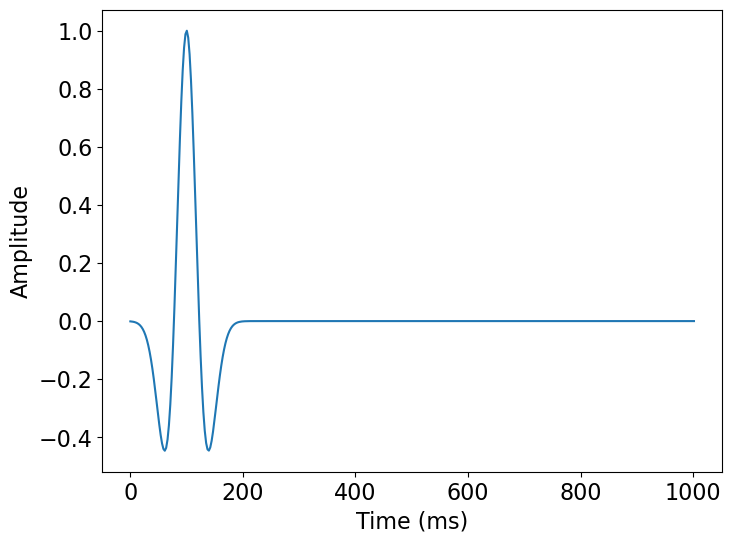

In [28]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import RickerSource #sparse vector

f0 = 0.010  # Source peak frequency is 10Hz (0.010 kHz)
src = RickerSource(name='src', grid=model.grid, f0=f0,
                   npoint=2, time_range=time_range) # Think about the string, grid of the source = grid of the string, here we inject the source to the 2D physical domain.
                                                    # Therefore, the grid we solving in the 2D problems
                                                    # Similar to the reciever, grid size = model.grid
                                                    # Use sparse matrix to present

# Set source coordinates
src.coordinates.data[:, 0] = [np.array(model.domain_size[0]) * .4, np.array(model.domain_size[0]) * .6]
src.coordinates.data[:, 1] = 20.  # Depth is 20m

# We can plot the time signature to see the wavelet via:
src.show()

In [29]:
src.data.shape

(410, 2)

Similarly to our source object, we can now define our receiver geometry as a symbol of type `Receiver`. It is worth noting here that both utility classes, `RickerSource` and `Receiver` are thin wrappers around Devito's `SparseTimeFunction` type, which encapsulates sparse point data and allows us to inject and interpolate values into and out of the computational grid. As we have already seen, both types provide a `.coordinates` property to define the position within the domain of all points encapsulated by that symbol. 

In this example we will position receivers at the same depth as the source, every $10m$ along the x axis. The `rec.data` property will be initialized, but left empty, as we will compute the receiver readings during the simulation.

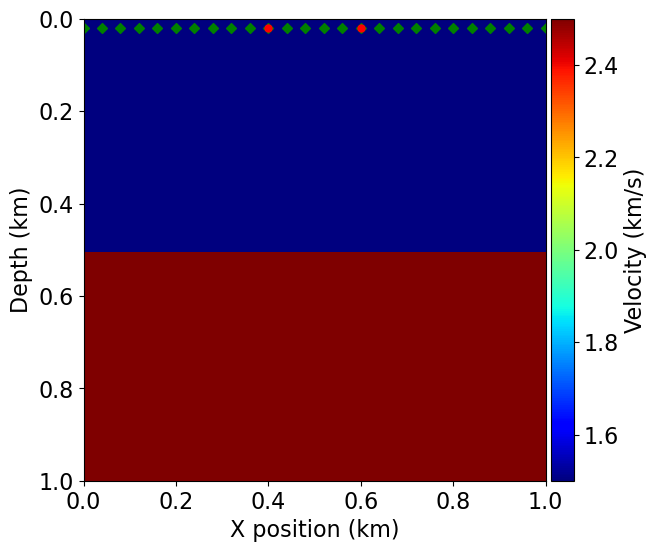

In [30]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import Receiver

# Create symbol for 101 receivers
rec = Receiver(name='rec', grid=model.grid, npoint=51, time_range=time_range)

# Prescribe even spacing for receivers along the x-axis
rec.coordinates.data[:, 0] = np.linspace(0, model.domain_size[0], num=51)
rec.coordinates.data[:, 1] = 20.  # Depth is 20m

# We can now show the source and receivers within our domain:
# Red dot: Source location
# Green dots: Receiver locations (every 4th point)
plot_velocity(model, source=src.coordinates.data,
              receiver=rec.coordinates.data[::2, :])

# Finite-difference discretization

The finite-difference approximation is derived from Taylor expansions of the continuous field after removing the error term.

## Time discretization

We only consider the second order time discretization for now. From the Taylor expansion, the second order discrete approximation of the second order time derivative is:
\begin{equation}
\begin{aligned}
 \frac{\partial^2 u(\mathbf{x},t)}{\partial t^2} = \frac{\mathbf{u}(\mathbf{x},\mathbf{t+\Delta t}) - 2 \mathbf{u}(\mathbf{x},\mathbf{t}) + \mathbf{u}(\mathbf{x},\mathbf{t-\Delta t})}{\mathbf{\Delta t}^2} + O(\mathbf{\Delta t}^2).
\end{aligned}
\end{equation} 

where $\mathbf{u}$ is the discrete wavefield, $\mathbf{\Delta t}$ is the discrete
time-step (distance between two consecutive discrete time points) and $O(\mathbf{\Delta
  t}^2)$ is the temporal discretization error term. The discretized approximation of the
second order time derivative is then given by dropping the error term. This derivative is represented in Devito by `u.dt2` where u is a `TimeFunction` object.

## Spatial discretization 

We define the discrete Laplacian as the sum of the second order spatial
derivatives in the three dimensions:
\begin{equation}
\begin{aligned}
\Delta \mathbf{u}(\mathbf{x},\mathbf{y},\mathbf{z},\mathbf{t})= \sum_{j=1}^{j=\frac{k}{2}} \Bigg[\alpha_j \Bigg(&
\mathbf{u}(\mathbf{x+jdx},\mathbf{y},\mathbf{z},\mathbf{t})+\mathbf{u}(\mathbf{x-jdx},\mathbf{y},\mathbf{z},\mathbf{t}) + \\
&\mathbf{u}(\mathbf{x},\mathbf{y+jdy},\mathbf{z},\mathbf{t})+\mathbf{u}(\mathbf{x},\mathbf{y-jdy},\mathbf{z}\mathbf{t}) + \\
&\mathbf{u}(\mathbf{x},\mathbf{y},\mathbf{z+jdz},\mathbf{t})+\mathbf{u}(\mathbf{x},\mathbf{y},\mathbf{z-jdz},\mathbf{t})\Bigg) \Bigg] + \\
&3\alpha_0 \mathbf{u}(\mathbf{x},\mathbf{y},\mathbf{z},\mathbf{t}).
\end{aligned}
\end{equation}

where $\alpha_j$ are the appropriate finite difference weights for the approximation. This derivative is represented in Devito by `u.laplace`.

## Wave equation

With the space and time discretization defined, we can fully discretize the wave-equation with the combination of time and space discretizations and obtain the following second order in time and $k^{th}$ order in space discrete stencil to update one grid point at position $\mathbf{x}, \mathbf{y},\mathbf{z}$ at time $\mathbf{t}$, i.e.
\begin{equation}
\begin{aligned}
\mathbf{u}(\mathbf{x},\mathbf{y},\mathbf{z},\mathbf{t+\Delta t}) = &2\mathbf{u}(\mathbf{x},\mathbf{y},\mathbf{z},\mathbf{t}) - \mathbf{u}(\mathbf{x},\mathbf{y}, \mathbf{z},\mathbf{t-\Delta t}) +\\
& \frac{\mathbf{\Delta t}^2}{\mathbf{m(\mathbf{x},\mathbf{y},\mathbf{z})}} \Big(\Delta \mathbf{u}(\mathbf{x},\mathbf{y},\mathbf{z},\mathbf{t}) + \mathbf{q}(\mathbf{x},\mathbf{y},\mathbf{z},\mathbf{t}) \Big). 
\end{aligned}
\end{equation}

In [31]:
# In order to represent the wavefield u and the square slowness we need symbolic objects 
# corresponding to time-space-varying field (u, TimeFunction) and 
# space-varying field (m, Function)
from devito import TimeFunction

# Define the wavefield with the size of the model and the time dimension
u = TimeFunction(name="u", grid=model.grid, time_order=2, space_order=2)

# We can now write the PDE
pde = model.m * u.dt2 - u.laplace + model.damp * u.dt

# The PDE representation is as on paper
pde



damp(x, y)*Derivative(u(t, x, y), t) - Derivative(u(t, x, y), (x, 2)) - Derivative(u(t, x, y), (y, 2)) + Derivative(u(t, x, y), (t, 2))/vp(x, y)**2

In [32]:
# This discrete PDE can be solved in a time-marching way updating u(t+dt) from the previous time step
# Devito as a shortcut for u(t+dt) which is u.forward. We can then rewrite the PDE as 
# a time marching updating equation known as a stencil using customized SymPy functions
from devito import Eq, solve

stencil = Eq(u.forward, solve(pde, u.forward))

# Source injection and receiver interpolation

With a numerical scheme to solve the homogenous wave equation, we need to add the source to introduce seismic waves and to implement the measurement operator, and interpolation operator. This operation is linked to the discrete scheme and needs to be done at the proper time step. The semi-discretized in time wave equation with a source reads:

\begin{equation}
\begin{aligned}
\mathbf{u}(\mathbf{x},\mathbf{y},\mathbf{z},\mathbf{t+\Delta t}) = &2\mathbf{u}(\mathbf{x},\mathbf{y},\mathbf{z},\mathbf{t}) - \mathbf{u}(\mathbf{x},\mathbf{y}, \mathbf{z},\mathbf{t-\Delta t}) +\\
& \frac{\mathbf{\Delta t}^2}{\mathbf{m(\mathbf{x},\mathbf{y},\mathbf{z})}} \Big(\Delta \mathbf{u}(\mathbf{x},\mathbf{y},\mathbf{z},\mathbf{t}) + \mathbf{q}(\mathbf{x},\mathbf{y},\mathbf{z},\mathbf{t}) \Big). 
\end{aligned}
\end{equation}

It shows that in order to update $\mathbf{u}$ to the time $\mathbf{t+\Delta t}$ we must inject the value of the source term $\mathbf{q}$ at time $\mathbf{t}$. In Devito, this corresponds to the update of $u$ at index $t+1$ (t = time implicitly) with the source of time $t$.

In [33]:
# injecting overtime

# Finally we define the source injection and receiver read function to generate the corresponding code
src_term = src.inject(field=u.forward, expr=src * dt**2 / model.m)

# Create interpolation expression for receivers
rec_term = rec.interpolate(expr=u.forward)

In [34]:
src

src(time, p_src)

# Devito operator and solve
After constructing all the necessary expressions for updating the wavefield, injecting the source term and interpolating onto the receiver points, we can now create the Devito operator that will generate the C code at runtime. When creating the operator, Devito's two optimization engines will log which performance optimizations have been performed:
* **DSE:** The Devito Symbolics Engine will attempt to reduce the number of operations required by the kernel.
* **DLE:** The Devito Loop Engine will perform various loop-level optimizations to improve runtime performance.

**Note**: The argument `subs=model.spacing_map` causes the operator to substitute values for our current grid spacing into the expressions before code generation. This reduces the number of floating point operations executed by the kernel by pre-evaluating certain coefficients.

In [35]:
#NBVAL_IGNORE_OUTPUT
from devito import Operator

# op = Operator([stencil] + src_term + rec_term, subs=model.spacing_map) # substitution
op = Operator([stencil] + src_term + rec_term, subs=model.spacing_map) # substitution

Now we can execute the create operator for a number of timesteps. We specify the number of timesteps to compute with the keyword `time` and the timestep size with `dt`.

In [37]:
#NBVAL_IGNORE_OUTPUT
op(time=time_range.num-1, dt=model.critical_dt)

Operator `Kernel` ran in 0.02 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.014263999999999943, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=3.5e-05, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section2', rank=None),
                     PerfEntry(time=0.00020399999999999967, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

After running our operator kernel, the data associated with the receiver symbol `rec.data` has now been populated due to the interpolation expression we inserted into the operator. This allows us the visualize the shot record:

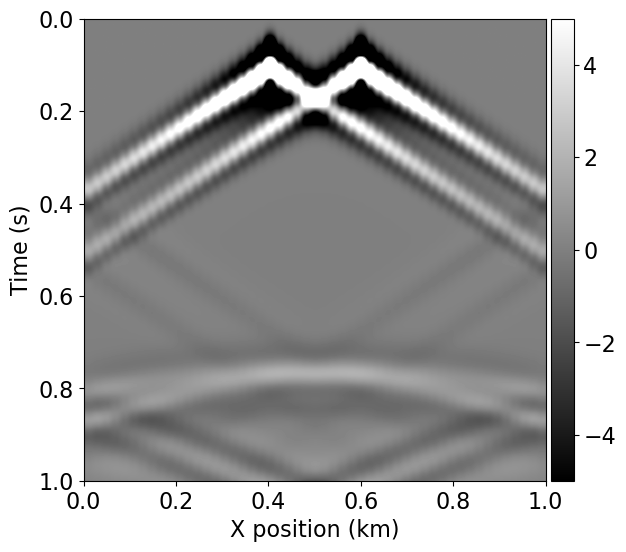

In [38]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import plot_shotrecord

plot_shotrecord(rec.data, model, t0, tn)

In [39]:
rec.data.shape

(410, 51)

In [40]:
rec.grid

Grid[extent=(1200.0, 1200.0), shape=(121, 121), dimensions=(x, y)]

In [41]:
model.grid

Grid[extent=(1200.0, 1200.0), shape=(121, 121), dimensions=(x, y)]

# Running Devito programs with MPI

MPI is immediatley supported for any Devito program. Simply type, e.g.:

```
DEVITO_MPI=1 mpirun <mpi args> python my_program.py
```

## Exercise: Run script with MPI

In the folder `additional_material` there is a python script named `acoustic_script.py` which essentially the python code introduced above but with the plotting instructions removed.

As a quick exercise, let us run this script with `mpirun` and satisfy ourselves that it returns the same results when run over 1 and 2 ranks:
- Before running with mpi we first need to install `mpi4py`. To do so, run the two following commands:
    - `sudo apt install mpich -y`
    - Then, in the `Devito` directory (`~/devito`) `pip install -r requirements-optional.txt --user`
- In the `additional_material` folder within the `transform2020` directory first run the script in serial: `python acoustic_script.py`.
- Then run over two mpi processes (`DEVITO_MPI=1 mpirun -np 2 python acoustic_script.py`) and check the resultant `norm` is the same. (Note 1: When running over two mpi processes each rank will print the norm to screen. Note 2: If executing via the jupyterhub terminal please do not run over 'too' many mpi processes as this may cause issues for other users.)